In [ ]:
import socket

try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in the top right and set 'Internet' switch to on")

In [ ]:
!pip install duckduckgo_search
!pip install fastai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/363.4 MB 81.9 MB/s eta 0:00:04

# 1. Download images of birds and non birds

In [ ]:
from duckduckgo_search import DDGS

def search_images(term, max_images=30):
  urls = []
  with DDGS() as ddgs:
    for r in ddgs.images(term, max_results=max_images):
      urls.append(r["image"])
    return urls

urls = search_images('bird photos', max_images=1)
urls[0]

'https://images.pexels.com/photos/326900/pexels-photo-326900.jpeg?cs=srgb&dl=wood-flight-bird-326900.jpg&fm=jpg'

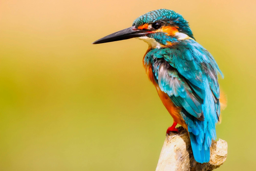

In [ ]:
from fastdownload import download_url
bird_dest = 'bird.jpg'
download_url(urls[0], bird_dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(bird_dest)
im.to_thumb(256, 256)

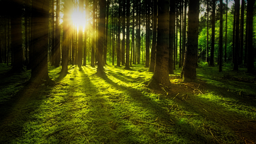

In [ ]:
forest_dest = 'forest.jpg'
download_url(search_images('forest photos', max_images=1)[0], forest_dest, show_progress=False)

Image.open(forest_dest).to_thumb(256, 256)

In [ ]:
search_terms = 'forest', 'bird'
path = Path('bird_or_not')

for term in search_terms:
  dest = (path/term)
  dest.mkdir(parents=True, exist_ok=True)
  download_images(dest, urls=search_images(f'{term} photo'))
  resize_images(path/term, max_size=400, dest=path/term)

# 2. Train our model

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

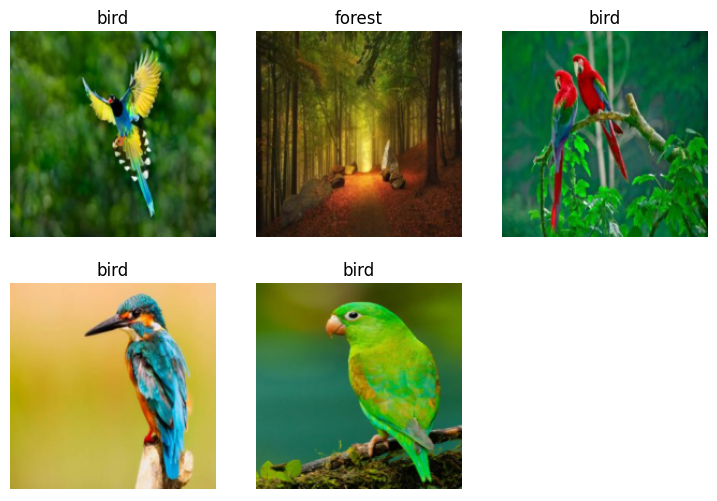

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n = 5)

Here what each of the DataBlock parameters means:

`blocks=(ImageBlock, CategoryBlock)`,

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

`get_items=get_image_files`,

To find all the inputs to our model, run the get_image_files function (which returns a list of all image files in a path).

`splitter=RandomSplitter(valid_pct=0.2, seed=42)`,

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

`get_y=parent_label`,

The labels (y values) is the name of the parent of each file (i.e. the name of the folder they're in, which will be bird or forest).

`item_tfms=[Resize(192, method='squish')]`

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).


In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.587186,0.457940,0.250000,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.934624,0.373852,0.250000,00:09
1,0.836360,0.164270,0.083333,00:10
2,0.564226,0.083771,0.000000,00:09


# 3. Use our model

In [ ]:
is_bird, _, probs = learn.predict(PILImage.create('bird.jpg'))
print(f'This is a: {is_bird}')
print(f'With a probability of: {probs[0]:.4f}')

This is a: bird
With a probability of: 1.0000
